# NiN(Network in Network)

**基本思想:** NiN网络的核心思想是将传统的卷积操作替换为"Micro Network"，通过逐元素操作在空间上对特征进行处理。这些 Micro Network 类似于小型的多层感知机，可以学习不同尺度和方向上的特征表示。

**1x1卷积:** NiN引入了 1x1 卷积层，用于对每个通道内的特征进行混合和变换。这些 1x1 卷积相当于对通道间的特征进行组合，从而可以更好地捕捉特征之间的关系。在 1x1 卷积之后，可以通过非线性激活来引入非线性特征变换，从而增强模型的表达能力。

**全局平均池化:** NiN网络的最后阶段采用全局平均池化，将最后一层的特征图平均化为一个固定大小的向量，然后接上一个全连接层进行分类。这种池化方式可以有效地减少参数数量，避免过拟合。


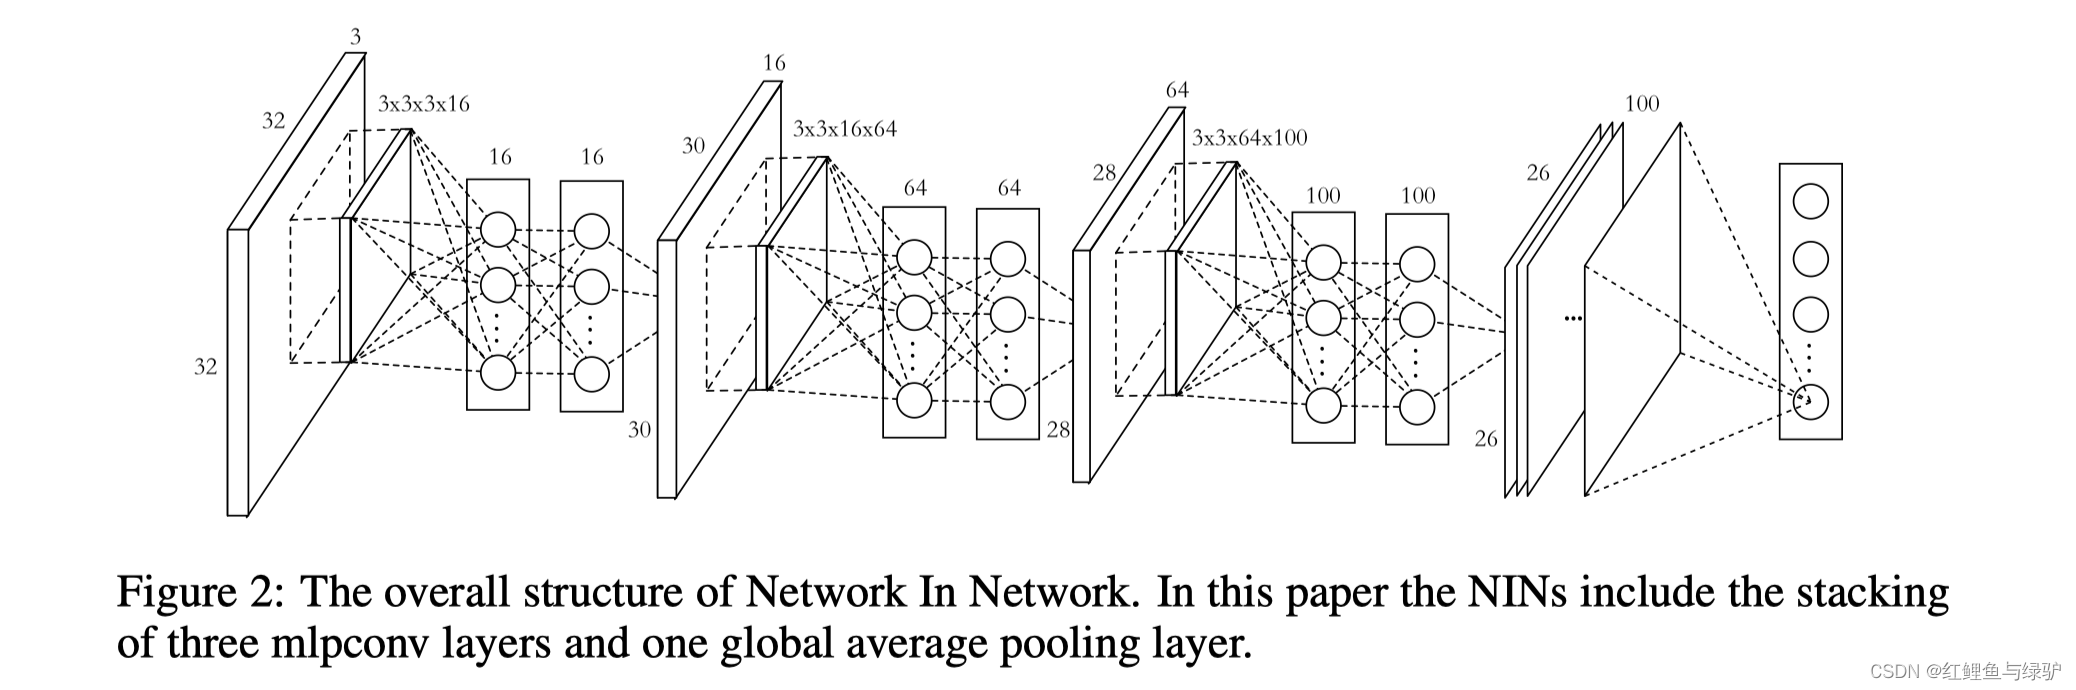

In [2]:
import torch
from torch import nn
from d2l import torch as d2l


# 定义NIN块(由1个标准卷积层加2个1x1卷积层组成)
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    """
    定义一个NIN块(Network In Network块)。

    参数:
    in_channels:输入通道数
    out_channels:输出通道数
    kernel_size:卷积核大小
    strides:卷积步长
    padding:卷积填充

    返回:
    一个包含多个卷积层和ReLU激活函数的Sequential模块
    """
    return nn.Sequential(
        # 第一个卷积层:普通卷积层
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        # 1x1卷积层(减小通道数并增强非线性能力)
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(),
        # 1x1卷积层
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU()
    )

## NiN模型

In [4]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    # 自适应平均池化层,输出大小1x1(将输入特征图池化到1x1大小)
    # 这样做的结果是将输入特征图中的每个通道内的所有值取平均，然后将每个通道内的平均值输出为一个标量
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten())

In [5]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## 训练模型

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

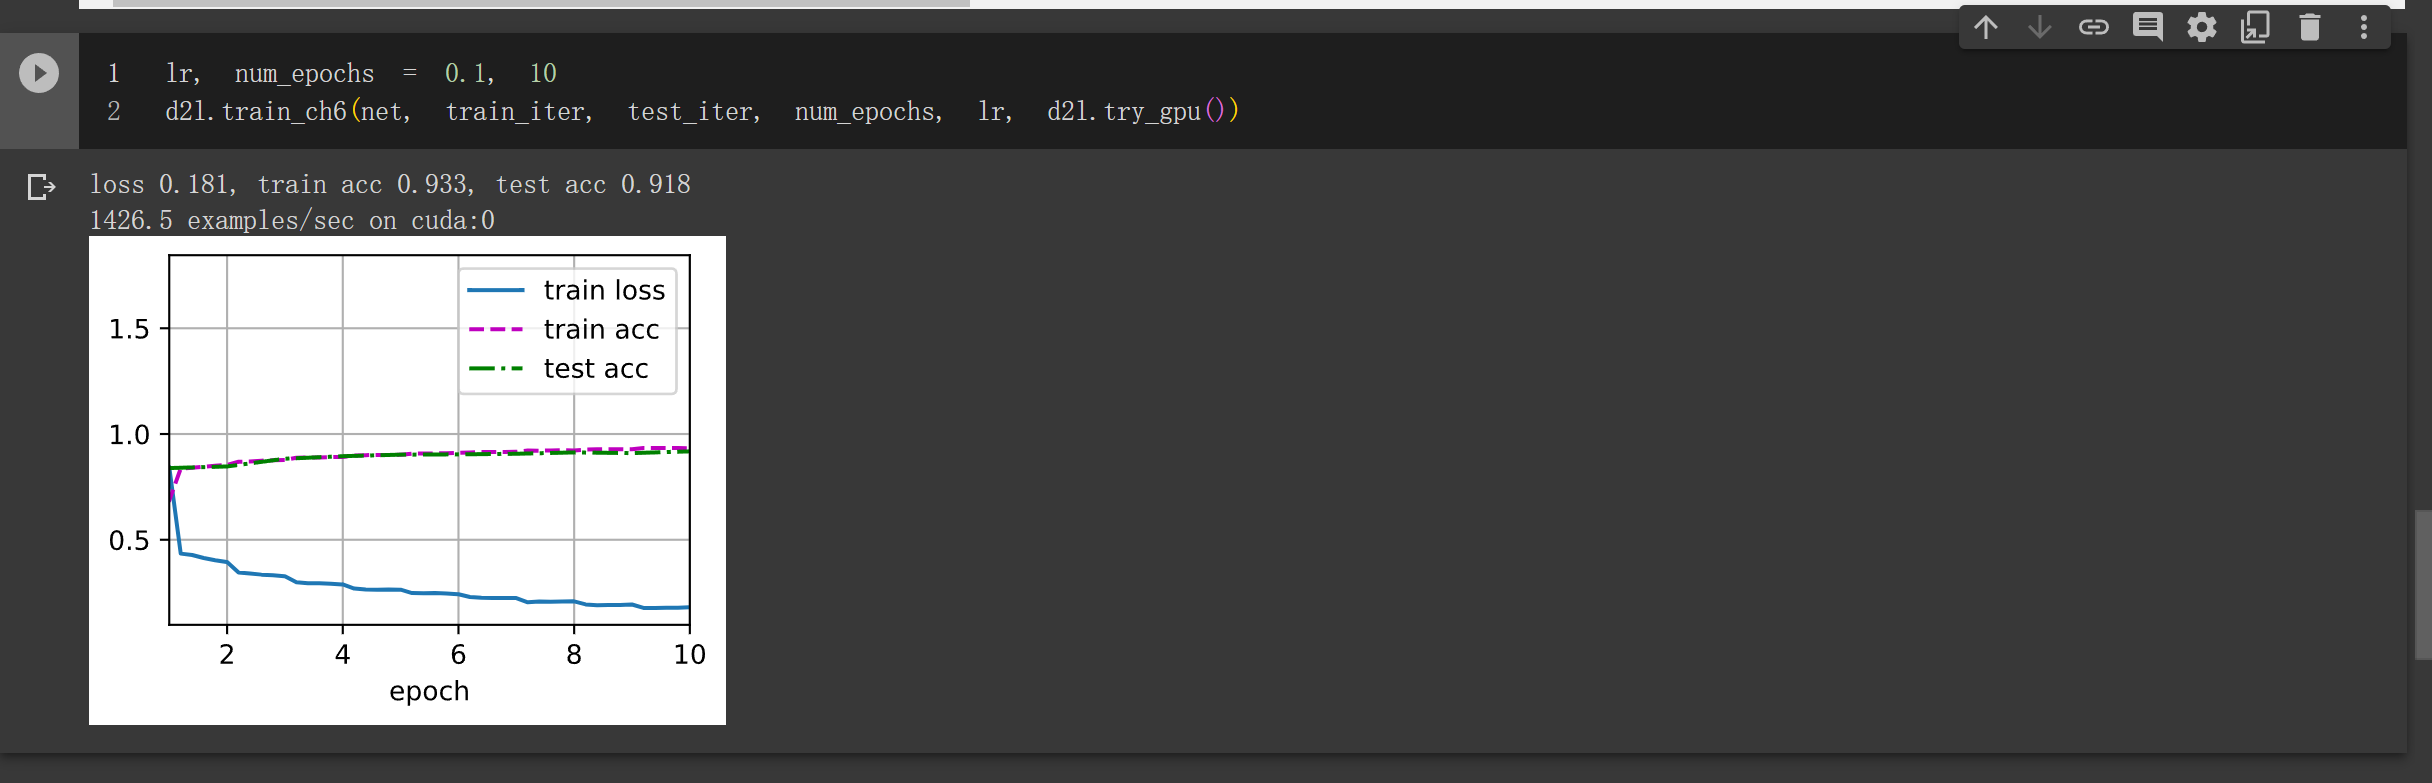